In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from ctrl_mult_mod import ctrl_mult_mod
from math import log2, pi

def semi_classical_QFT_inv(qc,q_reg,c_reg):
    """ Aplica a IQFT semi clássica
    
    qc : QuantumCircuit
        Circuito quântico para aplicar a IQFT
    q_reg : QuantumRegister
        Registrador quântico para a qft ser aplicada (será aplicada no 1o bit)
    c_reg : ClassicalRegister
        Registrador clássico para a medição dos qubits
    """
    try:
        n = q_reg.size
    except:
        n = len(q_reg)
    for i in range(n-1,-1,-1):
        for j in range(n-1,i,-1):
            with qc.if_test((c_reg[n-1-j],1)) as else_:
                qc.p((-pi/(2**(j-(i)))),q_reg[i])
            # with else_:
            #     pass
        qc.h(q_reg[i])
        qc.measure(q_reg[i],c_reg[n-1-i])


def semi_classical_QFT_inv_1_bit(qc, q_reg, c_reg, n):
    """ Aplica a IQFT semi clássica em um qubit
    
    qc : QuantumCircuit
        Circuito quântico para aplicar a IQFT
    q_reg : QuantumRegister
        Registrador quântico para a qft ser aplicada (será aplicada no 1o bit)
    c_reg : ClassicalRegister
        Registrador clássico para a medição dos qubits
    n : int
        Número de bits na IQFT original
    """

    for i in range(n-1,-1,-1):
        for j in range(n-1,i,-1):
            with qc.if_test((c_reg[n-1-j],1)) as else_:
                qc.p((-pi/(2**(j-(i)))), q_reg[0])
            # with else_:
            #     pass
        qc.h(q_reg[0])
        qc.measure(q_reg[0],c_reg[n-1-i])


def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1

    circuit.h(n)
    for qubit in range(n):
        if qubit >= 0:
            circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    return circuit

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n, do_swaps=False):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    if do_swaps:
        swap_registers(circuit, n)
    return circuit

def gcdExtended(a, b): 
    # Base Case 
    if a == 0 : 
        return b,0,1
             
    gcd,x1,y1 = gcdExtended(b%a, a) 
     
    # Update x and y using results of recursive 
    # call 
    x = y1 - (b//a) * x1 
    y = x1 
     
    return gcd,x,y 

def mod_inverse(x, p):
    """Retorna o inverso modular x^-1 mod p"""
    gcd, inv, _ = gcdExtended(x, p)
    if gcd != 1:
        raise ValueError("O inverso não existe")
    return inv % p

In [8]:
"""Valores:
    b*A^x mod N : x é o valor em superposição
    b é inicializado como 1.
    O valor da variável x_bits corresponde ao tamanho da amostra (2**x_bits).
"""

N = 77  # N = p*q; p, q primos
n_bits = int(log2(N))+1

A = 2 # Base do expoente

b = 1 # Registrador inicial da multiplicação

x_bits = 6 # q=2**x_bits, tamanho da amostra, idealmente é 2n_bits

reg_x = QuantumRegister(1, "x")
#number_x = QuantumCircuit(reg_x)

reg_b = QuantumRegister(n_bits, "b")

# Registradores Ancillas
reg_0 = QuantumRegister(n_bits, "0")

reg_cout = QuantumRegister(1, "cout")

reg_help = QuantumRegister(1, "help")

reg_result = ClassicalRegister(x_bits, "resultado")


#x_bits + 2*n_bits + 3
expmod = QuantumCircuit(reg_x, reg_b, reg_0, reg_cout, reg_help, name="expmod")

qc = QuantumCircuit(reg_x, reg_b, reg_0, reg_cout, reg_help, reg_result)

qc.x(reg_b[0])

for i in range(x_bits-1,-1,-1):
    
    qc.h(reg_x[0])
    qc.append(ctrl_mult_mod(n_bits, (A**(2**(i))) % N, N), reg_x[:] + reg_b[:] + reg_0[:] + reg_cout[:] + reg_help[:])

    a_inv = mod_inverse(A**(2**i), N)

    qc.append(ctrl_mult_mod(n_bits, a_inv, N).inverse(), reg_x[:] + reg_0[:] + reg_b[:] + reg_cout[:] + reg_help[:])

    for j in range(n_bits):
        qc.cswap(reg_x[0], reg_b[j], reg_0[j])

    for j in range(x_bits-1,i,-1):
        with qc.if_test((reg_result[x_bits-1-j],1)) as else_:
            qc.p((-pi/(2**(j-(i)))), reg_x[0])
    qc.h(reg_x[0])
    qc.measure(reg_x[0], reg_result[x_bits-1-i])
    qc.reset(reg_x[0])


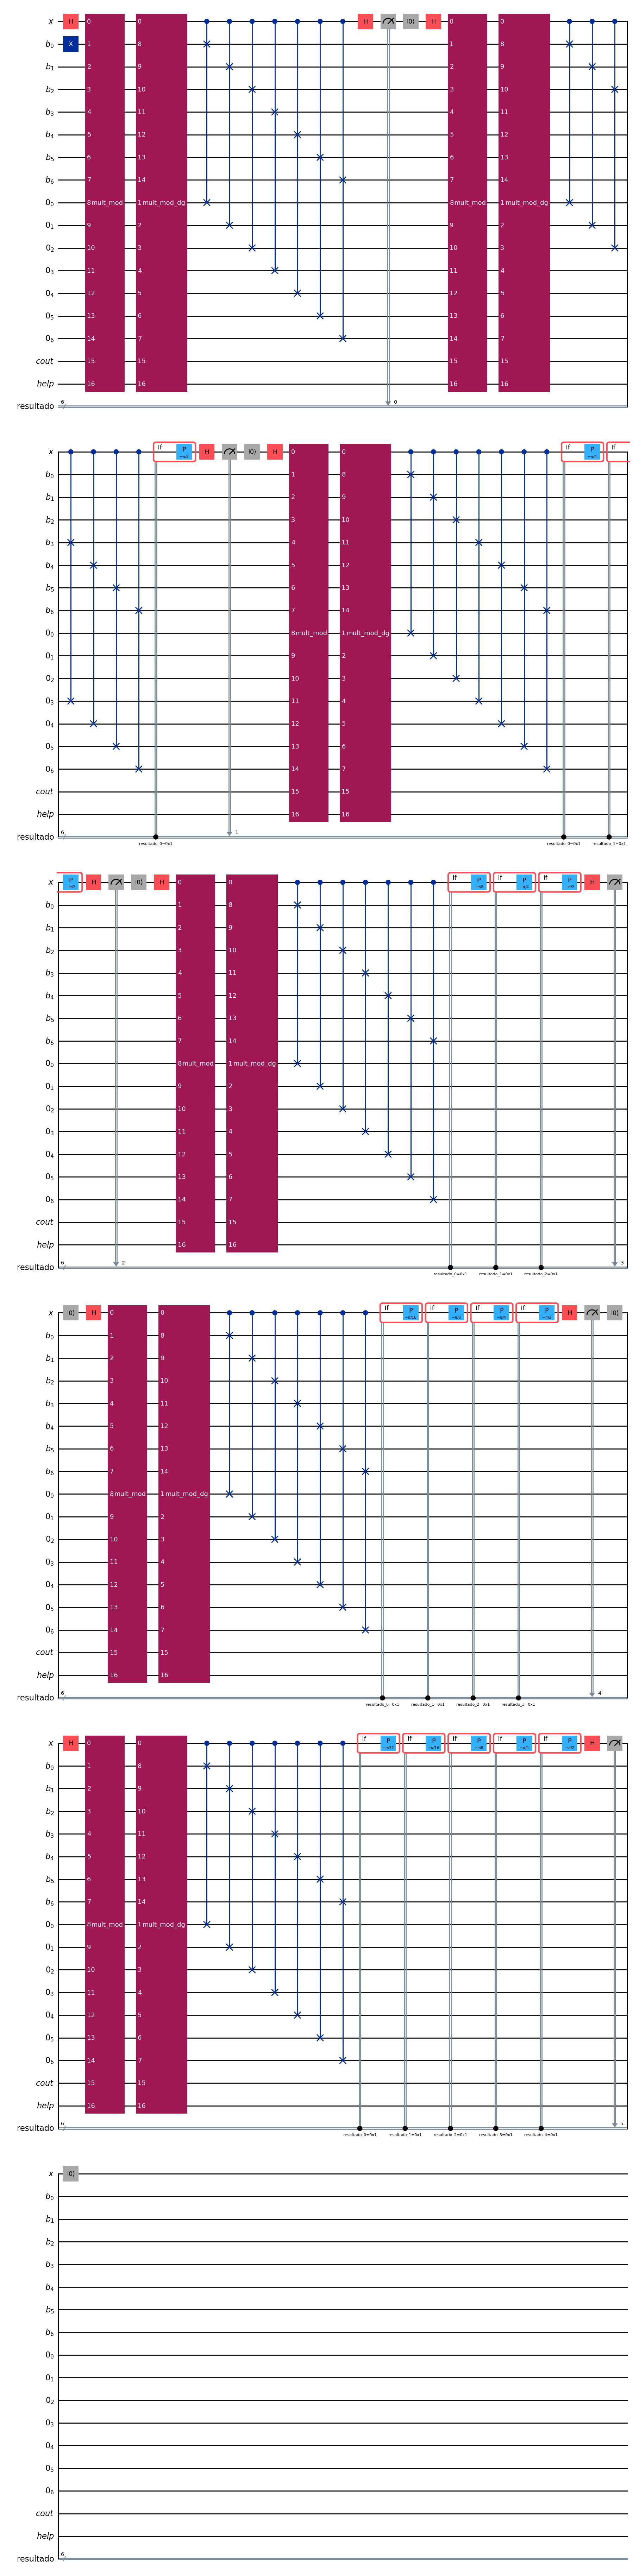

In [9]:
#expmod.draw("mpl")
qc.draw("mpl")

In [10]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler

backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1024)
print("b=" + str(b), "A=" + str(A), "N=" + str(N))

counts = job.result()[0].data.resultado.get_int_counts()

print(counts)


b=1 A=2 N=77
{19: 28, 4: 27, 7: 8, 2: 35, 13: 37, 28: 15, 6: 21, 23: 19, 44: 4, 17: 36, 62: 34, 9: 27, 47: 34, 59: 3, 36: 32, 21: 21, 53: 24, 45: 39, 24: 8, 32: 30, 51: 28, 30: 31, 15: 44, 8: 15, 0: 36, 42: 14, 63: 1, 40: 15, 38: 25, 33: 2, 54: 12, 26: 19, 52: 2, 58: 21, 60: 25, 11: 20, 25: 13, 43: 25, 55: 14, 49: 36, 41: 16, 34: 34, 56: 13, 5: 7, 10: 8, 16: 2, 27: 9, 3: 6, 61: 2, 39: 6, 37: 5, 22: 7, 57: 9, 20: 1, 46: 5, 29: 3, 12: 3, 14: 3, 48: 1, 1: 1, 35: 1, 18: 1, 50: 1}


In [11]:
Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(x_bits)):
  if i not in Resultado:
    Resultado[i] = 1

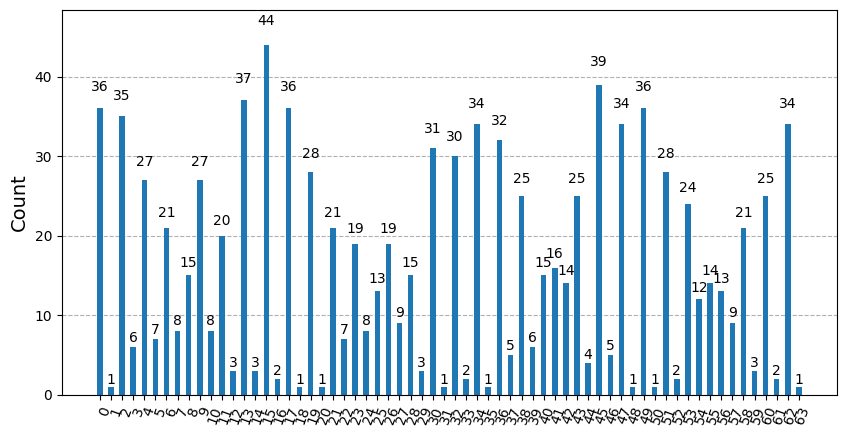

In [12]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado, figsize=(10,5))